C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 -- Text: Loss 0.2974, Acc 0.9015 | Image: Loss 1.4749, Acc 0.3357
Validation -- Text: Loss 0.0002, Acc 1.0000 | Image: Loss 1.3596, Acc 0.3846
Epoch 2/5 -- Text: Loss 0.0044, Acc 1.0000 | Image: Loss 0.9768, Acc 0.6923
Validation -- Text: Loss 0.0000, Acc 1.0000 | Image: Loss 0.9830, Acc 0.6643
Epoch 3/5 -- Text: Loss 0.0001, Acc 1.0000 | Image: Loss 0.7190, Acc 0.7972
Validation -- Text: Loss 0.0000, Acc 1.0000 | Image: Loss 0.6567, Acc 0.8112
Epoch 4/5 -- Text: Loss 0.0000, Acc 1.0000 | Image: Loss 0.4456, Acc 0.9161
Validation -- Text: Loss 0.0000, Acc 1.0000 | Image: Loss 0.3862, Acc 0.8741
Epoch 5/5 -- Text: Loss 0.0000, Acc 1.0000 | Image: Loss 0.3151, Acc 0.9091
Validation -- Text: Loss 0.0000, Acc 1.0000 | Image: Loss 0.2181, Acc 0.9510
Model saved to multimodal_model.pth

=== Text Validation Classification Report ===
                precision    recall  f1-score   support

       Healthy       1.00      1.00      1.00        34
       Mild DR       1.00      1.00    

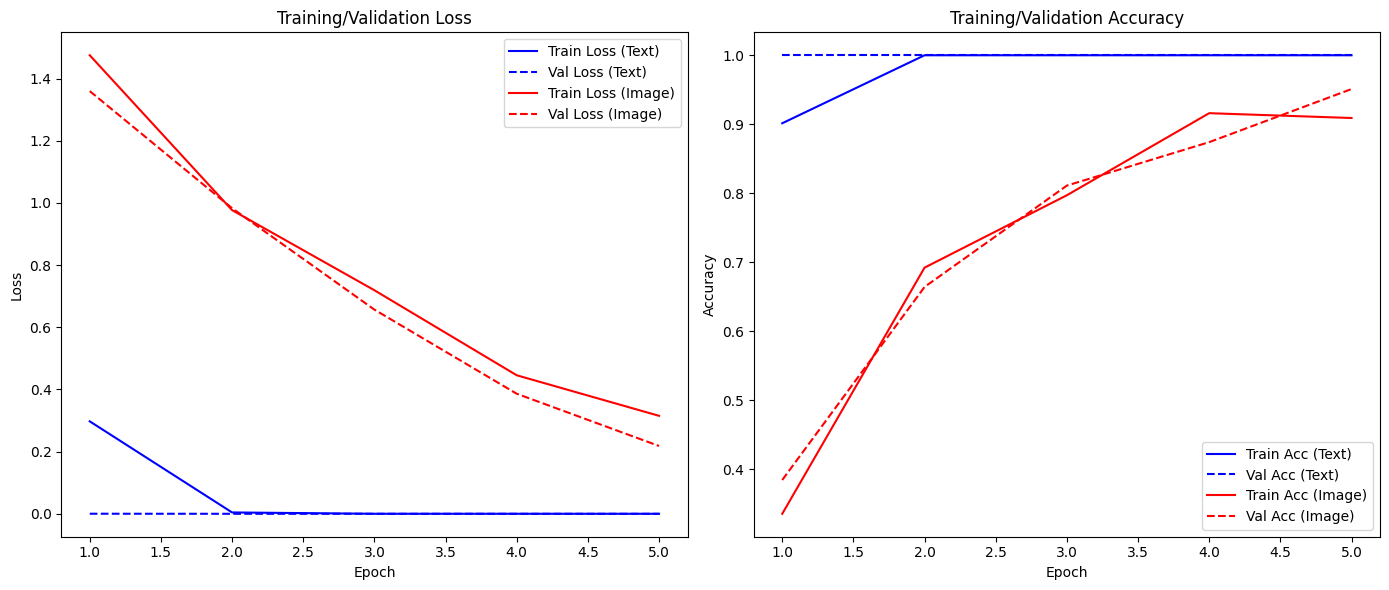

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
from torchvision import datasets, models
from transformers import BartModel, BartTokenizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

##########################################
# 1. Prepare the Text Dataset (CSV Data) #
##########################################

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        # Remove extra batch dimension from the tokenizer outputs
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Load the CSV file (it should contain columns: "label" and "panel_appearance")
text_df = pd.read_csv("dataset.csv")

# Create label mapping (assumes CSV "label" column)
label_list = text_df['label'].unique().tolist()
label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for label, idx in label2id.items()}
text_df['label_id'] = text_df['label'].map(label2id)

# Use the "panel_appearance" column as text and label_id as target
texts = text_df['symptoms'].tolist()
labels = text_df['label_id'].tolist()

# Split into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.33, random_state=42
)

# Load the BART tokenizer
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)

# Create DataLoaders for text data
text_train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_length=128)
text_val_dataset   = TextDataset(val_texts, val_labels, tokenizer, max_length=128)

text_train_loader = DataLoader(text_train_dataset, batch_size=2, shuffle=True)
text_val_loader   = DataLoader(text_val_dataset, batch_size=2, shuffle=False)

###############################################
# 2. Prepare the Image Dataset (Folder Data)  #
###############################################

# Define image transformations for training and validation
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}

# Set the paths to your image dataset folders (they should follow the ImageFolder structure)
image_data_dir =  r"C:\Users\home\OneDrive\Desktop\Final Year Project\MULITEMODEL_AI_EYE_DIS\TRAIN_CODE\colored_images"  # This folder should contain subfolders "train" and "val"
image_train_dir = os.path.join(image_data_dir, "train")
image_val_dir   = os.path.join(image_data_dir, "val")

# Create ImageFolder datasets
image_train_dataset = datasets.ImageFolder(image_train_dir, transform=image_transforms["train"])
image_val_dataset   = datasets.ImageFolder(image_val_dir, transform=image_transforms["val"])

# Create DataLoaders for image data
image_train_loader = DataLoader(image_train_dataset, batch_size=16, shuffle=True)
image_val_loader   = DataLoader(image_val_dataset, batch_size=16, shuffle=False)

# (Ensure that the class names in the image folders match those in the text CSV)
assert set(image_train_dataset.classes) == set(label_list), "Mismatch in classes between text and image datasets."

##############################################
# 3. Define the Multimodal Model Architecture #
##############################################

class MultiModalClassifier(nn.Module):
    def __init__(self, text_model, image_model, text_feat_dim, image_feat_dim, hidden_dim, num_classes):
        """
        text_model: Transformer model (e.g., BartModel) for text feature extraction.
        image_model: CNN model (e.g., ResNet18) for image feature extraction.
        text_feat_dim: Dimension of the text encoder output features.
        image_feat_dim: Dimension of the image encoder output features.
        hidden_dim: Common hidden dimension for projecting each modality's features.
        num_classes: Number of target classes.
        """
        super(MultiModalClassifier, self).__init__()
        self.text_model = text_model
        self.image_model = image_model
        
        # Linear layers to project modality-specific features to a common hidden space
        self.text_fc = nn.Linear(text_feat_dim, hidden_dim)
        self.image_fc = nn.Linear(image_feat_dim, hidden_dim)
        
        # Final classifier head that outputs logits for each class
        self.classifier = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, text_input=None, image_input=None):
        """
        Accepts either or both modalities.
        - text_input: a dictionary from the tokenizer (with keys like 'input_ids', 'attention_mask')
        - image_input: an image tensor
        If both modalities are provided, their features are averaged.
        """
        features = None
        
        if text_input is not None:
            # Remove 'labels' if present so that BART doesn't receive an unexpected key
            text_input_filtered = {k: v for k, v in text_input.items() if k != "labels"}
            text_outputs = self.text_model(**text_input_filtered)
            # Mean pooling over the sequence dimension (dim=1)
            pooled_text = text_outputs.last_hidden_state.mean(dim=1)
            text_features = self.text_fc(pooled_text)
            features = text_features if features is None else features + text_features
        
        if image_input is not None:
            # The image model should output a feature vector (with final fc replaced by Identity)
            image_features = self.image_model(image_input)
            image_features = self.image_fc(image_features)
            features = image_features if features is None else features + image_features
        
        # If both modalities are provided, average their features
        if (text_input is not None) and (image_input is not None):
            features = features / 2
        
        logits = self.classifier(features)
        return logits

#############################################
# 4. Instantiate the Encoders and the Model #
#############################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Text encoder: Load BartModel (without a classification head) for feature extraction.
text_encoder = BartModel.from_pretrained(model_name)
text_encoder.to(device)
text_feat_dim = text_encoder.config.d_model  # Typically 768 for bart-base

# Image encoder: Use a pretrained ResNet18 model.
image_encoder = models.resnet18(pretrained=True)
# Get the input features of the final fully connected layer before replacing it.
num_img_features = image_encoder.fc.in_features
# Replace the final fc layer with an identity layer to obtain a feature vector.
image_encoder.fc = nn.Identity()
image_encoder.to(device)
image_feat_dim = num_img_features  # Typically 512 for resnet18

# Set the hidden dimension for fusion and number of classes
hidden_dim = 512
num_classes = len(label_list)

# Create the multimodal model
model = MultiModalClassifier(
    text_model=text_encoder,
    image_model=image_encoder,
    text_feat_dim=text_feat_dim,
    image_feat_dim=image_feat_dim,
    hidden_dim=hidden_dim,
    num_classes=num_classes
)
model.to(device)

#######################################
# 5. Set Up the Training Components   #
#######################################

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 5  # Adjust as needed

# To record training metrics for plotting
train_loss_history_text = []
train_acc_history_text  = []
train_loss_history_image = []
train_acc_history_image  = []

val_loss_history_text = []
val_acc_history_text  = []
val_loss_history_image = []
val_acc_history_image  = []

#######################################
# 6. Training Loop (Alternating Modalities) #
#######################################

for epoch in range(num_epochs):
    model.train()
    # --- Train on Text Data ---
    running_loss_text = 0.0
    running_correct_text = 0
    total_text_samples = 0
    
    for batch in text_train_loader:
        optimizer.zero_grad()
        # Move all items in the batch to the device
        for key in batch:
            batch[key] = batch[key].to(device)
        labels = batch["labels"]
        # Forward pass using text modality only
        outputs = model(text_input=batch, image_input=None)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss_text += loss.item() * labels.size(0)
        preds = torch.argmax(outputs, dim=1)
        running_correct_text += (preds == labels).sum().item()
        total_text_samples += labels.size(0)
    
    epoch_loss_text = running_loss_text / total_text_samples
    epoch_acc_text  = running_correct_text / total_text_samples
    train_loss_history_text.append(epoch_loss_text)
    train_acc_history_text.append(epoch_acc_text)
    
    # --- Train on Image Data ---
    running_loss_image = 0.0
    running_correct_image = 0
    total_image_samples = 0
    
    for images, labels in image_train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass using image modality only
        outputs = model(text_input=None, image_input=images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss_image += loss.item() * labels.size(0)
        preds = torch.argmax(outputs, dim=1)
        running_correct_image += (preds == labels).sum().item()
        total_image_samples += labels.size(0)
    
    epoch_loss_image = running_loss_image / total_image_samples
    epoch_acc_image  = running_correct_image / total_image_samples
    train_loss_history_image.append(epoch_loss_image)
    train_acc_history_image.append(epoch_acc_image)
    
    print(f"Epoch {epoch+1}/{num_epochs} -- "
          f"Text: Loss {epoch_loss_text:.4f}, Acc {epoch_acc_text:.4f} | "
          f"Image: Loss {epoch_loss_image:.4f}, Acc {epoch_acc_image:.4f}")
    
    #########################################
    # Validation on Text and Image Data Separately
    #########################################
    model.eval()
    # --- Text Validation ---
    val_loss_text = 0.0
    val_correct_text = 0
    total_val_text = 0
    all_text_preds = []
    all_text_labels = []
    with torch.no_grad():
        for batch in text_val_loader:
            for key in batch:
                batch[key] = batch[key].to(device)
            labels = batch["labels"]
            outputs = model(text_input=batch, image_input=None)
            loss = criterion(outputs, labels)
            val_loss_text += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_text_preds.extend(preds.cpu().numpy())
            all_text_labels.extend(labels.cpu().numpy())
            val_correct_text += (preds == labels).sum().item()
            total_val_text += labels.size(0)
    avg_val_loss_text = val_loss_text / total_val_text
    avg_val_acc_text = val_correct_text / total_val_text
    val_loss_history_text.append(avg_val_loss_text)
    val_acc_history_text.append(avg_val_acc_text)
    
    # --- Image Validation ---
    val_loss_image = 0.0
    val_correct_image = 0
    total_val_image = 0
    all_image_preds = []
    all_image_labels = []
    with torch.no_grad():
        for images, labels in image_val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(text_input=None, image_input=images)
            loss = criterion(outputs, labels)
            val_loss_image += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_image_preds.extend(preds.cpu().numpy())
            all_image_labels.extend(labels.cpu().numpy())
            val_correct_image += (preds == labels).sum().item()
            total_val_image += labels.size(0)
    avg_val_loss_image = val_loss_image / total_val_image
    avg_val_acc_image = val_correct_image / total_val_image
    val_loss_history_image.append(avg_val_loss_image)
    val_acc_history_image.append(avg_val_acc_image)
    
    print(f"Validation -- Text: Loss {avg_val_loss_text:.4f}, Acc {avg_val_acc_text:.4f} | "
          f"Image: Loss {avg_val_loss_image:.4f}, Acc {avg_val_acc_image:.4f}")

#########################################
# 7. Save the Trained Model
#########################################
MODEL_SAVE_PATH = "multimodal_model.pth"
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

#########################################
# 8. Final Evaluation: Classification Reports and Confusion Matrices
#########################################

# For text evaluation, include all classes (even if some have 0 support)
print("\n=== Text Validation Classification Report ===")
print(classification_report(all_text_labels, all_text_preds, labels=list(range(len(label_list))), target_names=label_list))
print("Confusion Matrix (Text):")
print(confusion_matrix(all_text_labels, all_text_preds))

print("\n=== Image Validation Classification Report ===")
print(classification_report(all_image_labels, all_image_preds, labels=list(range(len(image_train_dataset.classes))), target_names=image_train_dataset.classes))
print("Confusion Matrix (Image):")
print(confusion_matrix(all_image_labels, all_image_preds))

#########################################
# 9. Plot Training and Validation Curves
#########################################

epochs_arr = np.arange(1, num_epochs+1)

plt.figure(figsize=(14, 6))
# Loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs_arr, train_loss_history_text, 'b-', label="Train Loss (Text)")
plt.plot(epochs_arr, val_loss_history_text, 'b--', label="Val Loss (Text)")
plt.plot(epochs_arr, train_loss_history_image, 'r-', label="Train Loss (Image)")
plt.plot(epochs_arr, val_loss_history_image, 'r--', label="Val Loss (Image)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training/Validation Loss")
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs_arr, train_acc_history_text, 'b-', label="Train Acc (Text)")
plt.plot(epochs_arr, val_acc_history_text, 'b--', label="Val Acc (Text)")
plt.plot(epochs_arr, train_acc_history_image, 'r-', label="Train Acc (Image)")
plt.plot(epochs_arr, val_acc_history_image, 'r--', label="Val Acc (Image)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training/Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

#########################################
# 10. Inference Functions for the Multimodal Model
#########################################

def inference_text(model, tokenizer, text, device, max_length=128):
    """Perform inference on text input only."""
    model.eval()
    encoding = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    # Move encoding to device
    for key in encoding:
        encoding[key] = encoding[key].to(device)
    with torch.no_grad():
        logits = model(text_input=encoding, image_input=None)
    pred_id = torch.argmax(logits, dim=1).item()
    return id2label[pred_id]

def inference_image(model, image_path, transform, device):
    """Perform inference on an image input only."""
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # add batch dimension
    image = image.to(device)
    with torch.no_grad():
        logits = model(text_input=None, image_input=image)
    pred_id = torch.argmax(logits, dim=1).item()
    return id2label[pred_id]

def inference_both(model, tokenizer, text, image_path, transform, device, max_length=128):
    """Perform inference using both text and image inputs."""
    model.eval()
    # Process text input
    encoding = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    for key in encoding:
        encoding[key] = encoding[key].to(device)
    # Process image input
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    image = image.to(device)
    with torch.no_grad():
        logits = model(text_input=encoding, image_input=image)
    pred_id = torch.argmax(logits, dim=1).item()
    return id2label[pred_id]


In [ ]:
# Example text inference
sample_text = "No symptoms, Clear vision, No pain or discomfort, Normal eye appearance, No redness or swelling, No light sensitivity"
predicted_label_text = inference_text(model, tokenizer, sample_text, device)
print(f"Predicted label from text: {predicted_label_text}")

# Example image inference:
# Make sure that 'sample_image.jpg' exists in your working directory.
sample_image_path = r"C:\Users\home\OneDrive\Desktop\Final Year Project\MULITEMODEL_AI_EYE_DIS\TRAIN_CODE\dataset\train\Mild DR\Mild_DR.png"
predicted_label_image = inference_image(model, sample_image_path, image_transforms["val"], device)
print(f"Predicted label from image: {predicted_label_image}")

# Example combined inference:
predicted_label_both = inference_both(model, tokenizer, sample_text, sample_image_path, image_transforms["val"], device)
print(f"Predicted label from both modalities: {predicted_label_both}")

Predicted label from text: Healthy
Predicted label from image: Mild DR
Predicted label from both modalities: Healthy
